# Main Idea
First of all, I started to consider an algorithm that can distinguish unsolvable inputs from solvable ones. As many other participants had noticed, this can be done simply by solving the Maximum Matching Problem on a bipartile graph. Here I give a simple proof:
## Proof
* * *
Let $G = \{V=R∪C,E\}$ be a bipartile graph where $ R=\{R_1,R_2,R_3,R_4\}$,$ C=\{C_1,C_2,C_3,C_4\}$, and $E=\{\{R_n,C_m\}|\{n,m\}$ is in the input$\} $. Each Vertex represents either row or column of the board. It is easy to see that selecting three rows or columns to shoot lasor beam is equivalent to selecting three vertexes out of $V$, and whether all asteroids can be destroyed or not corresponds to whether the selected vertexes compose a Vertex cover of the graph. Therefore, if the board is solvable with $k$ laser beams, then the size of the Minimum Vertex cover is equal to $k$, and vice versa. Consequently, if a board is unsolvable, then its graph has no Vertex cover whose size is three or less, and must have a perfect matching. The converse also holds.
* * *
With this proof, there are several ways to construct the oracle part. One approach is to regard the board as (reduced) adjacency matrix. In this case, a perfect matching on a bipartile graph can be depicted as permutation matrix, thus it is possible to solve the problem by checking whether the adjacency matrix contains any permutation matrix. For expample, if the board contains four asteroids on (1,2), (2,4), (3,1), and (4,3), the board is unsolvable since they make up a permutation matrix.

Another possible solution is to check whether the parmanent of the adjacency matrix is 0 or not.(Note: permanent is defined as is written here https://en.wikipedia.org/wiki/Permanent_(mathematics)) Mathematically, this approach is completely equivalent to the former one.

My solution is based on the latter idea, and by encoding the board directly into each component, I reduced the cost of board preparation. In addition to that, I divided the calculation into 2 parts, since if not it would require at least 24 qubits alone (and there would be no room for ancilla).

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


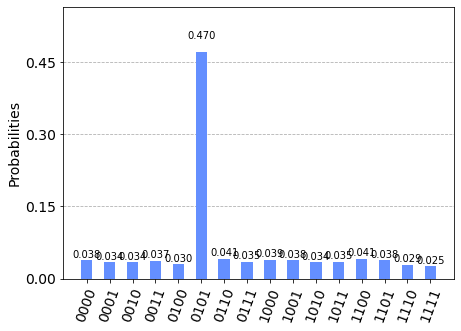

In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.visualization import plot_histogram

provider = IBMQ.load_account()
provider.get_backend('ibmq_qasm_simulator')

problem_set = \
    [[['0', '2'], ['1', '0'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '3']],
    [['0', '0'], ['1', '1'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '1'], ['1', '3'], ['3', '2'], ['3', '3']],
    [['0', '2'], ['1', '0'], ['1', '3'], ['2', '0'], ['3', '2'], ['3', '3']],
    [['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '1'], ['3', '3']],
    [['0', '2'], ['0', '3'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
    [['0', '0'], ['0', '3'], ['1', '2'], ['2', '2'], ['2', '3'], ['3', '0']],
    [['0', '3'], ['1', '1'], ['1', '2'], ['2', '0'], ['2', '1'], ['3', '3']],
    [['0', '0'], ['0', '1'], ['1', '3'], ['2', '1'], ['2', '3'], ['3', '0']],
    [['0', '1'], ['0', '3'], ['1', '2'], ['1', '3'], ['2', '0'], ['3', '2']],
    [['0', '0'], ['1', '3'], ['2', '0'], ['2', '1'], ['2', '3'], ['3', '1']],
    [['0', '1'], ['0', '2'], ['1', '0'], ['1', '2'], ['2', '2'], ['2', '3']],
    [['0', '3'], ['1', '0'], ['1', '3'], ['2', '1'], ['2', '2'], ['3', '0']],
    [['0', '2'], ['0', '3'], ['1', '2'], ['2', '3'], ['3', '0'], ['3', '1']],
    [['0', '1'], ['1', '0'], ['1', '2'], ['2', '2'], ['3', '0'], ['3', '1']]]

import itertools

def week3_ans_func(problem_set):
    data = [[[int([str(i),str(j)] in k) for j in range(4)] for i in range(4)] for k in problem_set]
    
    address = QuantumRegister(4)
    register = QuantumRegister(24)
    cr = ClassicalRegister(4)
    qc = QuantumCircuit(address, register,cr)
    # address preparation
    qc.h(address[:])

    for i in range(1):
        oracle(qc,address,register,data)
        diffusion(qc,address,register)

    qc.measure(address,cr)
    # Change the endian 
    qc = qc.reverse_bits() 
    
    return qc

def oracle(circuit,address,register,data):
    for i in range(16):
        for n in range(4):
            if not i & (1<<n):
                circuit.x(address[n])
        perm = [c for c in itertools.permutations([0,1,2,3], 4)]
        for m in range(16):
            a,b,c,d = perm[m]
            if data[i][0][a] and data[i][1][b] and data[i][2][c] and data[i][3][d]:
                circuit.mct(address[:],register[m], register[-2:], mode='basic')
        for n in range(4):
            if not i & (1<<n):
                circuit.x(address[n])
    circuit.x(register[:16])
    circuit.mct(register[:8],register[22],register[16:22],  mode='basic')
    circuit.mct(register[8:16], register[23],register[16:22],  mode='basic')
    circuit.x(register[:16])
    for i in range(16):
        for n in range(4):
            if not i & (1<<n):
                circuit.x(address[n])
        perm = [c for c in itertools.permutations([0,1,2,3], 4)]
        for m in range(16):
            a,b,c,d = perm[m]
            if data[i][0][a] and data[i][1][b] and data[i][2][c] and data[i][3][d]:
                circuit.mct(address[:],register[m], register[-4:-2], mode='basic')
        for m in range(16,24):
            a,b,c,d = perm[m]
            if data[i][0][a] and data[i][1][b] and data[i][2][c] and data[i][3][d]:
                circuit.mct(address[:],register[m-16], register[-4:-2], mode='basic')
        for n in range(4):
            if not i & (1<<n):
                circuit.x(address[n])
    circuit.x(register[:8])
    circuit.x(register[16])
    circuit.h(register[16])
    circuit.mct(register[:8]+register[-2:],register[16], register[8:16], mode='basic')
    circuit.h(register[16])
    circuit.x(register[16])
    circuit.x(register[:8])
    for i in range(16):
        for n in range(4):
            if not i & (1<<n):
                circuit.x(address[n])
        perm = [c for c in itertools.permutations([0,1,2,3], 4)]
        for m in range(16,24):
            a,b,c,d = perm[m]
            if data[i][0][a] and data[i][1][b] and data[i][2][c] and data[i][3][d]:
                circuit.mct(address[:],register[m-16], register[-4:-2], mode='basic')
        for m in range(16):
            a,b,c,d = perm[m]
            if data[i][0][a] and data[i][1][b] and data[i][2][c] and data[i][3][d]:
                circuit.mct(address[:],register[m], register[-4:-2], mode='basic')
        for n in range(4):
            if not i & (1<<n):
                circuit.x(address[n])
    circuit.x(register[:16])
    circuit.mct(register[:8],register[22],register[16:22],  mode='basic')
    circuit.mct(register[8:16], register[23],register[16:22],  mode='basic')
    circuit.x(register[:16])
    for i in range(16):
        for n in range(4):
            if not i & (1<<n):
                circuit.x(address[n])
        perm = [c for c in itertools.permutations([0,1,2,3], 4)]
        for m in range(16):
            a,b,c,d = perm[m]
            if data[i][0][a] and data[i][1][b] and data[i][2][c] and data[i][3][d]:
                circuit.mct(address[:],register[m], register[-2:], mode='basic')
        for n in range(4):
            if not i & (1<<n):
                circuit.x(address[n])
    
def diffusion(circuit,ad,auxiliary):
    circuit.h(ad[:])
    circuit.x(ad[:])
    circuit.h(ad[3])
    circuit.mct(ad[0:3], ad[3], auxiliary[:], mode='basic')
    circuit.h(ad[3])
    circuit.x(ad[:])
    circuit.h(ad[:])
    

backend = provider.get_backend('ibmq_qasm_simulator')
shots = 1024
results = execute(week3_ans_func(problem_set), backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)